<a href="https://colab.research.google.com/github/itberrios/CV_tracking/blob/main/kitti_tracker/2_kitti_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **KITTI Tracking**

In this tutorial we will learn how to track objects in 3D on the KITTI dataset. We will build off of our object dector from part 1 and use each obejct detection to update the tracks.

For more information a readme for the KITTI data can be found [here](https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT), and a paper that details the data collection and coordinate systems can be found [here](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf). 

<br>

## Get the data

In [1]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip

--2022-09-23 00:49:30--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.170.205
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.170.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3103291675 (2.9G) [application/zip]
Saving to: ‘2011_10_03_drive_0047_sync.zip’

2011_10_03_drive_00 100%[===================>]   2.89G  13.5MB/s    in 3m 42s  

2022-09-23 00:53:13 (13.3 MB/s) - ‘2011_10_03_drive_0047_sync.zip’ saved [3103291675/3103291675]



In [2]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip

--2022-09-23 00:53:13--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.170.65
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.170.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4075 (4.0K) [application/zip]
Saving to: ‘2011_10_03_calib.zip’

2011_10_03_calib.zi 100%[===================>]   3.98K  --.-KB/s    in 0s      

2022-09-23 00:53:14 (230 MB/s) - ‘2011_10_03_calib.zip’ saved [4075/4075]



In [3]:
!jar xf 2011_10_03_drive_0047_sync.zip
!jar xf 2011_10_03_calib.zip

## Base Library Import

In [43]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

## Import Utility functions

In [2]:
!wget https://github.com/itberrios/CV_tracking/raw/main/kitti_tracker/kitti_utils.py
from kitti_utils import *

--2022-09-23 02:09:32--  https://github.com/itberrios/CV_tracking/raw/main/kitti_tracker/kitti_utils.py
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/itberrios/CV_tracking/main/kitti_tracker/kitti_utils.py [following]
--2022-09-23 02:09:33--  https://raw.githubusercontent.com/itberrios/CV_tracking/main/kitti_tracker/kitti_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9721 (9.5K) [text/plain]
Saving to: ‘kitti_utils.py’

kitti_utils.py      100%[===================>]   9.49K  --.-KB/s    in 0s      

2022-09-23 02:09:33 (69.4 MB/s) - ‘kitti_utils.py’ saved [9721/9721]



In [61]:

!wget https://github.com/itberrios/CV_tracking/raw/main/kitti_tracker/kitti_detection_utils.py
from kitti_detection_utils import *

--2022-09-23 02:15:20--  https://github.com/itberrios/CV_tracking/raw/main/kitti_tracker/kitti_detection_utils.py
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/itberrios/CV_tracking/main/kitti_tracker/kitti_detection_utils.py [following]
--2022-09-23 02:15:20--  https://raw.githubusercontent.com/itberrios/CV_tracking/main/kitti_tracker/kitti_detection_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5405 (5.3K) [text/plain]
Saving to: ‘kitti_detection_utils.py’

kitti_detection_uti 100%[===================>]   5.28K  --.-KB/s    in 0s      

2022-09-23 02:15:20 (65.1 MB/s) - ‘kitti

## Get Data Paths

In [4]:
DATA_PATH = r'2011_10_03/2011_10_03_drive_0047_sync'

# get RGB camera data
left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))

# get GPS/IMU data
oxts_paths = sorted(glob(os.path.join(DATA_PATH, r'oxts/data**/*.txt')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")
print(f"Number of GPS/IMU frames: {len(oxts_paths)}")

Number of left images: 837
Number of right images: 837
Number of LiDAR point clouds: 837
Number of GPS/IMU frames: 837


## Get Camera Transformation Matrices

In [5]:
with open('2011_10_03/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices (rectified left camera --> left camera (u,v,z))
P_rect2_cam2 = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))


# get rectified rotation matrices (left camera --> rectified left camera)
R_ref0_rect2 = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))

# add (0,0,0) translation and convert to homogeneous coordinates
R_ref0_rect2 = np.insert(R_ref0_rect2, 3, values=[0,0,0], axis=0)
R_ref0_rect2 = np.insert(R_ref0_rect2, 3, values=[0,0,0,1], axis=1)


# get rigid transformation from Camera 0 (ref) to Camera 2
R_2 = np.array([float(x) for x in calib[21].strip().split(' ')[1:]]).reshape((3,3))
t_2 = np.array([float(x) for x in calib[22].strip().split(' ')[1:]]).reshape((3,1))

# get cam0 to cam2 rigid body transformation in homogeneous coordinates
T_ref0_ref2 = np.insert(np.hstack((R_2, t_2)), 3, values=[0,0,0,1], axis=0)

## Get LiDAR and IMU Transformation matrices

In [6]:
T_velo_ref0 = get_rigid_transformation(r'2011_10_03/calib_velo_to_cam.txt')
T_imu_velo = get_rigid_transformation(r'2011_10_03/calib_imu_to_velo.txt')

#### Get LiDAR ⬌ Camera2 Rotation matrices

LiDAR &rarr; Cam Ref 0 &rarr; Cam Ref 2 &rarr; Rectified 2 &rarr; Camera 2

In [7]:
# transform from velo (LiDAR) to left color camera (shape 3x4)
T_velo_cam2 = P_rect2_cam2 @ R_ref0_rect2 @ T_ref0_ref2 @ T_velo_ref0 

# homogeneous transform from left color camera to velo (LiDAR) (shape: 4x4)
T_cam2_velo = np.linalg.inv(np.insert(T_velo_cam2, 3, values=[0,0,0,1], axis=0)) 

#### Get IMU ⬌ Camera2 Rotation matrices

IMU &rarr; LiDAR &rarr; Cam Ref 0 &rarr; Cam Ref 2 &rarr; Rectified 2 &rarr; Camera 2

In [8]:
# transform from IMU to left color camera (shape 3x4)
T_imu_cam2 = T_velo_cam2 @ T_imu_velo

# homogeneous transform from left color camera to IMU (shape: 4x4)
T_cam2_imu = np.linalg.inv(np.insert(T_imu_cam2, 3, values=[0,0,0,1], axis=0)) 

## **Get Object Detection pipeline**

In [ ]:
!git clone https://github.com/ultralytics/yolov5

In [ ]:
!pip install -r yolov5/requirements.txt  #Install whatever is needed

In [10]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-9-23 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [11]:
# set confidence and IOU thresholds
model.conf = 0.25  # confidence threshold (0-1), default: 0.25
model.iou = 0.25  # NMS IoU threshold (0-1), default: 0.45

## **Set up tracking pipeline**

The tracking will be a 3D real world extension of the [SORT algorithm](https://arxiv.org/pdf/1602.00763.pdf). Instead of tracking bounding box location and aspect, we will simple track the (x, y, z) locations of each detected object. Even though we can esily neglect the z-axis, we will include it to keep our coordinate trasnformations easier. In our Kalman Filter we will use a constanct velocity model with a random accleration assumption.

The tracking pipeline will use the object detection methods from part 1 as a backbone. The L2 distance between object (x,y,z) centers will be used as a cost. The Hungarian Algorithm (linear_sum_assignemnt in Python) will be used to match old tracks with new updates and determine if tracks are not updated.

In [12]:
from scipy.optimize import linear_sum_assignment

# helper functions
def total_cost(center1, center2):
    ''' Return L2 distance between object centers '''
    return np.linalg.norm(center1 - center2)


def associate(old_centers, new_centers, dist_thresh=1):
    """
    Inputs:
        old_centers - former center locations (at time 0)
        new_centers - new center locations (at time 1)
        dist_thresh - distance threshold to declare tracks matched or unmatched
    Outputs:
       matches - Matched tracks
       unmatched_detections - Unmatched Detections
       unmatched_trackers - Unmatched Tracks

    """
    if (len(new_centers) == 0) and (len(old_centers) == 0):
        return [], [], []
    elif(len(old_centers)==0):
        return [], new_centers, []
    elif(len(new_centers)==0):
        return [], [], old_centers

    # distances will store L2 distances between object centers
    distances = np.zeros((len(old_centers),len(new_centers)),dtype=np.float32)

    # Go through centers and store the L2 distances between all of them
    for i,old_cntr in enumerate(old_centers):
        for j,new_cntr in enumerate(new_centers):
            distances[i][j] = total_cost(old_cntr, new_cntr)


    # Hungarian Algorithm (with L2 distance metric as the cost)
    row_ind, col_ind = linear_sum_assignment(distances)
    hungarian_matrix = np.array(list(zip(row_ind, col_ind)))

    # Create new unmatched lists for old and new boxes
    matches, unmatched_detections, unmatched_tracks = [], [], []

    # Go through the Hungarian Matrix, if matched element has dist <= threshold (0.3), add it to the unmatched 
    # Else: add the match    
    for h in hungarian_matrix:
        if(distances[h[0],h[1]] > dist_thresh):
            unmatched_tracks.append(old_centers[h[0]])
            unmatched_detections.append(new_centers[h[1]])
        else:
            matches.append(h.reshape(1,2))

    if(len(matches)==0):
        matches = np.empty((0,2), dtype=int)
    else:
        matches = np.concatenate(matches, axis=0)

    # Go through old centers, if no matched detection, add it to the unmatched_old_centers
    for t, trk in enumerate(old_centers):
        if(t not in hungarian_matrix[:,0]):
            unmatched_tracks.append(trk)

    # Go through new boxes, if no matched tracking, add it to the unmatched_new_centers
    for d, det in enumerate(new_centers):
        if(d not in hungarian_matrix[:,1]):
            unmatched_detections.append(det)

    return matches, unmatched_detections, unmatched_tracks
  

## Test track pipeline

In [62]:
index1 = 20
index2 = 21
index3 = 22
index4 = 23

left_image_1 = cv2.cvtColor(cv2.imread(left_image_paths[index1]), cv2.COLOR_BGR2RGB)
bin_path_1 = bin_paths[index1]

left_image_2 = cv2.cvtColor(cv2.imread(left_image_paths[index2]), cv2.COLOR_BGR2RGB)
bin_path_2 = bin_paths[index2]

left_image_3 = cv2.cvtColor(cv2.imread(left_image_paths[index3]), cv2.COLOR_BGR2RGB)
bin_path_3 = bin_paths[index3]

left_image_4 = cv2.cvtColor(cv2.imread(left_image_paths[index4]), cv2.COLOR_BGR2RGB)
bin_path_4 = bin_paths[index2]

In [63]:
imu_xyz_1 = get_imu_xyz(left_image_1, bin_path_1, model, T_velo_cam2, T_cam2_imu)

In [64]:
imu_xyz_2 = get_imu_xyz(left_image_2, bin_path_2, model, T_velo_cam2, T_cam2_imu)

In [49]:
imu_xyz_3 = get_imu_xyz(left_image_3, bin_path_3, model, T_velo_cam2, T_cam2_imu)
imu_xyz_4 = get_imu_xyz(left_image_4, bin_path_4, model, T_velo_cam2, T_cam2_imu)

In [50]:
imu_xyz_1

array([[     11.911,      -2.722,    -0.16906],
       [     15.574,       7.346,    -0.16672],
       [     11.089,      3.1335,    -0.13419],
       [     23.339,     -2.8507,   -0.010265],
       [     22.384,      3.5784,   -0.070647],
       [     46.072,      0.4007,     0.27154],
       [     29.946,      3.2677,   -0.044347],
       [       56.6,      -2.106,    -0.24867],
       [     13.094,      2.8895,     0.36942],
       [     52.366,      4.0757,     0.11331],
       [     45.877,     -3.0317,   0.0097941],
       [     23.318,      2.8036,   -0.096056]])

In [18]:
imu_xyz_2

array([[     15.315,       7.299,     -0.1505],
       [     11.965,      -2.751,    -0.10473],
       [     11.027,      3.1306,    -0.12802],
       [      23.49,     -2.8317,   -0.016854],
       [     22.356,      3.6084,   -0.070034],
       [     29.881,      3.2596,   -0.042096],
       [     57.115,     -1.8578,    -0.26439],
       [     46.409,     0.33389,     0.26685],
       [     52.351,      3.9927,     0.11557],
       [     31.399,      7.6322,    -0.18401],
       [     46.348,     -3.0605, -0.00073378]])

In [19]:
matches, unmatched_detections, unmatched_tracks = associate(imu_xyz_1, imu_xyz_2, dist_thresh=1)

In [20]:
matches

array([[ 0,  1],
       [ 1,  0],
       [ 2,  2],
       [ 3,  3],
       [ 4,  4],
       [ 5,  7],
       [ 6,  5],
       [ 7,  6],
       [ 9,  8],
       [10, 10]])

In [21]:
imu_xyz_2[matches[:, 1]]

array([[     11.965,      -2.751,    -0.10473],
       [     15.315,       7.299,     -0.1505],
       [     11.027,      3.1306,    -0.12802],
       [      23.49,     -2.8317,   -0.016854],
       [     22.356,      3.6084,   -0.070034],
       [     46.409,     0.33389,     0.26685],
       [     29.881,      3.2596,   -0.042096],
       [     57.115,     -1.8578,    -0.26439],
       [     52.351,      3.9927,     0.11557],
       [     46.348,     -3.0605, -0.00073378]])

In [22]:
unmatched_detections

[array([     31.399,      7.6322,    -0.18401])]

In [23]:
unmatched_tracks

[array([     23.318,      2.8036,   -0.096056]),
 array([     13.094,      2.8895,     0.36942])]

In [ ]:
!wget https://github.com/ultralytics/yolov5/raw/master/data/coco.yaml

In [25]:
import yaml

with open('coco.yaml', "r") as stream:
    try:
        classes = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [140]:
def get_color(idx):
    '''returns a random color seeded from the input index '''
    blue = idx*5 % 256
    green = idx*15 % 256
    red = idx*25 % 256
    return (red, green, blue)


def draw_boxes(image_in, boxes, categories, color, mot_mode=False):
    image = image_in.copy()
    h, w, _ = image.shape
    for i, box in enumerate(boxes):
        label = classes[int(categories[i])]
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, thickness=2)
        cv2.putText(image, str(label), (int(box[0]), int(box[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=2)
    return image

In [141]:
# track params
class Track():
    def __init__(self, idx, xyz, color, cat=0, kf=None):
        ''' 
          idx - track index
          xyz - track center in IMU (x, y, z) coordinates
          color - color for the object and it's bounding box
          cat - track category
          kf - KalmanFilter Object for tracking
          age - track age, number of frames track has been observed
          hit_streak - simultaneuos hits
          unmatched_age - number of frames track has not been observed
          fov - (_Bool) indicates that the object is approaching edge of FOV
          '''
          
        self.idx = idx
        self.xyz = xyz
        self.color = color
        self.cat = cat
        self.kf = kf
        self.age = 0 # number of frames track has been observed
        self.hit_streak = 0
        self.unmatched_age = 0 # number of frames track has not been observed
        self.fov = 0 # indicates that the object is approaching edge of FOV
        self.history = [xyz] # initialize track (x,y,z) history

    def update(self, new_xyz):
        ''' Update function for a given track object '''

        # update position with Kalman Filter
        # TBD
        # track.kf.update() ?? find a quick way to do this

        # move bounding box
        # TBD find a good way to do this
        
        # update with new measurement (TEMP without Kalman Filter)
        self.xyz = new_xyz

        # update Kalman Filter State with new obs
        # TBD
        # self.kf.update(new_xyz)

        # reset age
        self.age = 0

        # update history
        self.history.append(self.xyz)



In [142]:
# tracker params
MIN_HIT_STREAK = 1
MAX_UNMATCHED_AGE = 2

class Tracker():
    def __init__(self,  max_age=1, min_hits=3, dist_threshold=1):
        ''' 
            Inputs:
                max_age - max number of updates for a track to be declared lost
                min_hits - minnumber of hits/matches for a track to be declared
                dist_threshold - min L2 distance for a track to be considered
            Outputs:
                ret_tracks - returned tracks list after min hits and age out
            '''
        self.max_age = max_age
        self.min_hits = min_hits
        self.dist_threshold = dist_threshold
        self.tracks = []
        self.track_idx = 0 # unique track index
        self.frame_count = 0 # frames 
    
    def update(self, detections):
        ''' Update the tracks with new detections 
            Inputs: detections - Nx3 array of (x, y, z) object locations
            Outputs: ret_tracks - list of new track objects that are filtered
                out based on min hits required for a track to be shown
            '''
        # increment frame count
        self.frame_count += 1
        
        # get track centers for association
        tracks_xyz = [trk.xyz for trk in self.tracks]
        
        # associate new detections with current tracks (Hungarian)
        matches, unmatched_dets, unmatched_trks = associate(tracks_xyz,
                                                            detections, 
                                                            self.dist_threshold)
        # print(unmatched_dets)
        # print(unmatched_trks)

        # get returnable tracks list
        ret_tracks = []

        # update matches
        for (old_idx, new_idx) in matches:

            # get new detection coordinates
            new_xyz = detections[new_idx]

            # update track
            self.tracks[old_idx].update(new_xyz)

            # update hit streak
            self.tracks[old_idx].hit_streak += 1

            # add to new tracks
            if self.tracks[old_idx].hit_streak >= self.min_hits:
                ret_tracks.append(self.tracks[old_idx])


        # get indexes of tracks to delete
        to_del = []

        # handle unmatched observations
        for old_xyz in unmatched_trks:

            # get old track index 
            trk_idx = np.where(tracks_xyz == old_xyz)[0][0]

            # increment age
            self.tracks[trk_idx].age += 1

            # if track age too large, then remove it
            if self.tracks[trk_idx].age > self.max_age:
                # del self.tracks[trk_idx]
                to_del.append(trk_idx)
            else:

                # # get predicted state from previous data
                # obs.kf.predict()

                # # move box to newly predicted location for next iteration
                # obs.box = move_box(obs.box, obs.kf.x[0], obs.kf.x[2]) 

                # # determine if object is in FOV
                # obs.fov = detect_fov(obs.box)

                # add to new tracks
                ret_tracks.append(self.tracks[trk_idx])

        # delete tracks
        self.tracks[:] = [trk for i, trk in enumerate(self.tracks) 
                                                      if i not in to_del]

        # get new observations
        for new_xyz in unmatched_dets:

            # # cat = categories[out_boxes.index(new_obs)]

            # # cat = categories[np.where(out_boxes == new_obs)[0][0]] # only if using arrays
            # obs = Obstacle(idx, new_obs, constantVelocity_KF(R_std_v, Q_std_v, dt_v), 
            #               cat=cat, age=0, unmatched_age=0)
            
            # get new track
            color = get_color(self.track_idx)
            track = Track(self.track_idx, new_xyz, color)

            
            # # get initial Kalman Filter Prediction
            # track.kf.predict()
            # # update first Kalman Filter State with observation
            # track.kf.update(new_xyz)

            # # move box to newly predicted location for next iteration
            # # obs.box = move_box(new_obs, obs.kf.x[0], obs.kf.x[2]) 

            # or just do this
            # track.update(new_xyz)

            # # or just use initial measurement for first box position

            # new_obstacles.append(obs)

            # incerement unique track indexes
            self.track_idx += 1

            # add to tracks list
            self.tracks.append(track)


        return ret_tracks

    def seed(self, detections):
        ''' seeds the tracker with initial detections '''
        pass

In [68]:
# initiate the tracker
tracker = Tracker(max_age=2, min_hits=1, dist_threshold=0.75)

In [69]:
# seed tracker with first set of detections
tracker.update(imu_xyz_1)
for trk in tracker.tracks:
    print(trk.idx, trk.hit_streak, trk.age, trk.xyz)

0 0 0 [     11.911      -2.722    -0.16906]
1 0 0 [     15.574       7.346    -0.16672]
2 0 0 [     11.089      3.1335    -0.13419]
3 0 0 [     23.339     -2.8507   -0.010265]
4 0 0 [     22.384      3.5784   -0.070647]
5 0 0 [     46.072      0.4007     0.27154]
6 0 0 [     29.946      3.2677   -0.044347]
7 0 0 [       56.6      -2.106    -0.24867]
8 0 0 [     13.094      2.8895     0.36942]
9 0 0 [     52.366      4.0757     0.11331]
10 0 0 [     45.877     -3.0317   0.0097941]
11 0 0 [     23.318      2.8036   -0.096056]


In [70]:
# get next track update
new_tracks = tracker.update(imu_xyz_2)
for trk in new_tracks:
    print(trk.idx, trk.hit_streak, trk.age, trk.xyz)

0 1 0 [     11.965      -2.751    -0.10473]
1 1 0 [     15.315       7.299     -0.1505]
2 1 0 [     11.027      3.1306    -0.12802]
3 1 0 [      23.49     -2.8317   -0.016854]
4 1 0 [     22.356      3.6084   -0.070034]
5 1 0 [     46.409     0.33389     0.26685]
6 1 0 [     29.881      3.2596   -0.042096]
7 1 0 [     57.115     -1.8578    -0.26439]
9 1 0 [     52.351      3.9927     0.11557]
10 1 0 [     46.348     -3.0605 -0.00073378]
11 0 1 [     23.318      2.8036   -0.096056]
8 0 1 [     13.094      2.8895     0.36942]


In [71]:
new_tracks = tracker.update(imu_xyz_3)
for trk in new_tracks:
    print(trk.idx, trk.hit_streak, trk.age, trk.xyz)

0 2 0 [     12.072     -2.7741     -0.1156]
1 2 0 [     15.056      7.2771    -0.13465]
2 2 0 [     10.967      3.1456    -0.12312]
3 2 0 [     23.599     -2.9167   -0.021815]
4 2 0 [     22.238      3.5874   -0.063484]
5 2 0 [     46.754     0.41106     0.26001]
6 2 0 [      29.78      3.2476   -0.038713]
7 2 0 [     57.599     -1.8706    -0.27518]
9 2 0 [     52.317      3.9897     0.11568]
12 1 0 [     31.265      7.5982    -0.17923]
8 0 2 [     13.094      2.8895     0.36942]
10 1 1 [     46.348     -3.0605 -0.00073378]
11 0 2 [     23.318      2.8036   -0.096056]


In [72]:
new_tracks = tracker.update(imu_xyz_4)
for trk in new_tracks:
    print(trk.idx, trk.hit_streak, trk.age, trk.xyz)

0 3 0 [     11.965      -2.751    -0.10473]
1 3 0 [     15.238      7.5199    -0.15562]
2 3 0 [     10.999      3.1566    -0.12635]
3 3 0 [      23.49     -2.8317   -0.016854]
4 3 0 [     22.366      3.6454   -0.070603]
5 3 0 [     46.417     0.54887     0.26365]
6 3 0 [     29.881      3.2596   -0.042096]
7 3 0 [     57.115     -1.8578    -0.26439]
9 3 0 [     52.351      3.9927     0.11557]
12 2 0 [     31.405      7.6852     -0.1858]
10 1 2 [     46.348     -3.0605 -0.00073378]


In [73]:
for trk in tracker.tracks:
    print(trk.idx, trk.hit_streak, trk.age, trk.xyz)

0 3 0 [     11.965      -2.751    -0.10473]
1 3 0 [     15.238      7.5199    -0.15562]
2 3 0 [     10.999      3.1566    -0.12635]
3 3 0 [      23.49     -2.8317   -0.016854]
4 3 0 [     22.366      3.6454   -0.070603]
5 3 0 [     46.417     0.54887     0.26365]
6 3 0 [     29.881      3.2596   -0.042096]
7 3 0 [     57.115     -1.8578    -0.26439]
9 3 0 [     52.351      3.9927     0.11557]
10 1 2 [     46.348     -3.0605 -0.00073378]
12 2 0 [     31.405      7.6852     -0.1858]
13 0 0 [     17.687      7.1737    0.039574]


## **Tracking Pipeline**

In [143]:
def get_detections(image, bin_path, model, T_velo_cam, T_cam_imu):
     ''' Obtains (x,y,z) locations referenced to IMU and image bounding boxes
         Camera reference specified by image and Transformation Matrices, 
         Can use any camera as the reference
         '''
     # get detections and object centers in uvz
     bboxes, velo_uvz = get_detection_coordinates(image, 
                                                  bin_path, 
                                                  model, 
                                                  T_velo_cam,
                                                  draw_boxes=False,
                                                  draw_depth=True)

     # get transformed coordinates of object centers
     uvz = bboxes[:, -3:]

     # transform to IMU (u,v,z)
     imu_xyz = transform_uvz(uvz, T_cam_imu)
      
     return bboxes, imu_xyz

In [144]:
# initiate the tracker
tracker = Tracker(max_age=2, min_hits=1, dist_threshold=0.75)

for index in range(2):
    left_image = cv2.cvtColor(cv2.imread(left_image_paths[index1]), cv2.COLOR_BGR2RGB)
    bin_path = bin_paths[index1]

    bboxes, imu_xyz = get_detections(left_image, bin_path, model, T_velo_cam2, T_cam2_imu)

    new_tracks = tracker.update(imu_xyz)

    # draw boxes on new tracks
    for trk in new_tracks:
        xyzw = np.hstack((trk.xyz, 1))[:, None]
        uvz = xyzw2camera(xyzw, T_imu_cam2, left_image)

        # center = (int(np.round(uvz[0][0])), 
        #           int(np.round(uvz[1][0])))

        # cv2.circle(left_image, center, 5, trk.color, -1);

        # associate track with bbox?

        # need to pass bbox pts to tracker so tracker can update locations

In [145]:
for trk in tracker.tracks:
    print(trk.idx, trk.hit_streak, trk.age, trk.xyz)

0 1 0 [     11.911      -2.722    -0.16906]
1 1 0 [     15.574       7.346    -0.16672]
2 1 0 [     11.089      3.1335    -0.13419]
3 1 0 [     23.339     -2.8507   -0.010265]
4 1 0 [     22.384      3.5784   -0.070647]
5 1 0 [     46.072      0.4007     0.27154]
6 1 0 [     29.946      3.2677   -0.044347]
7 1 0 [       56.6      -2.106    -0.24867]
8 1 0 [     13.094      2.8895     0.36942]
9 1 0 [     52.366      4.0757     0.11331]
10 1 0 [     45.877     -3.0317   0.0097941]
11 1 0 [     23.318      2.8036   -0.096056]


In [146]:
for trk in new_tracks:
    print(trk.idx, trk.hit_streak, trk.age, trk.xyz)

0 1 0 [     11.911      -2.722    -0.16906]
1 1 0 [     15.574       7.346    -0.16672]
2 1 0 [     11.089      3.1335    -0.13419]
3 1 0 [     23.339     -2.8507   -0.010265]
4 1 0 [     22.384      3.5784   -0.070647]
5 1 0 [     46.072      0.4007     0.27154]
6 1 0 [     29.946      3.2677   -0.044347]
7 1 0 [       56.6      -2.106    -0.24867]
8 1 0 [     13.094      2.8895     0.36942]
9 1 0 [     52.366      4.0757     0.11331]
10 1 0 [     45.877     -3.0317   0.0097941]
11 1 0 [     23.318      2.8036   -0.096056]


In [147]:
imu_xyz

array([[     11.911,      -2.722,    -0.16906],
       [     15.574,       7.346,    -0.16672],
       [     11.089,      3.1335,    -0.13419],
       [     23.339,     -2.8507,   -0.010265],
       [     22.384,      3.5784,   -0.070647],
       [     46.072,      0.4007,     0.27154],
       [     29.946,      3.2677,   -0.044347],
       [       56.6,      -2.106,    -0.24867],
       [     13.094,      2.8895,     0.36942],
       [     52.366,      4.0757,     0.11331],
       [     45.877,     -3.0317,   0.0097941],
       [     23.318,      2.8036,   -0.096056]])

In [156]:
bboxes[0, :]

array([     712.24,      192.23,      840.38,      283.87,     0.91373,           2,      775.19,      240.27,      10.822])

In [157]:
xyzw = np.hstack((new_tracks[0].xyz, 1))[:, None]
uvz = xyzw2camera(xyzw, T_imu_cam2, left_image)
uvz

array([[     775.19],
       [     240.27],
       [     10.822]])

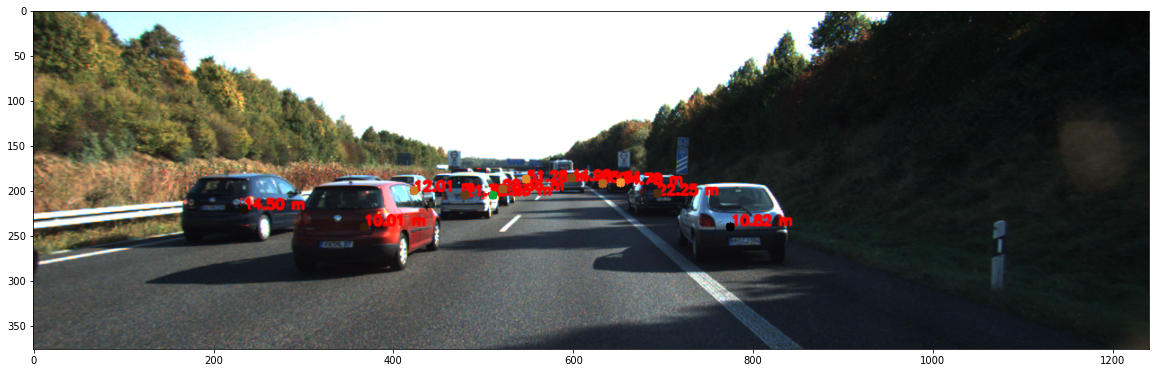

In [149]:
plt.imshow(left_image);

In [155]:
new_tracks[3].color

(75, 45, 15)